In [67]:
import pandas as pd
import numpy as np
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K

from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
import json
from keras.models import model_from_json

import seaborn as sns
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
df= pd.read_csv("../../data_fer/fer2013.csv")

In [3]:
ruta= "../../data_fer/fer2013.csv"

## Change emotion numbers for their names

In [4]:
emotions= ('Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral')
df['emotion_name']=df.emotion.apply(lambda x: emotions[x])

In [5]:
df.head()

,emotion,pixels,Usage,emotion_name
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,Angry
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,Angry
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,Fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,Sad
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,Neutral


In [6]:
df.pixels.shape

(35887,)

## Transform data into an array and get X, Y

In [7]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [8]:
X, Y = getData(ruta)
num_class = len(set(Y))
print(num_class)

7


In [9]:
X.dtype

dtype('float64')

In [10]:
X.shape

(35887, 2304)

In [11]:
df["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [12]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [13]:
X.shape

(35887, 48, 48, 1)

## Split data for train and test model

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [ ]:
img_rows, img_cols = 48,48
if K.image_data_format() == 'channels_first':
    X_train = x_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = x_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


## Define CNN

In [16]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()
    
    return model
model=my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

## Train model

In [18]:
path_model='model_filter.h5' # save model at this location after each epoch
K.clear_session() 
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=90, 
            epochs=25, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Epoch 1/25
339/339 [==============================] - 1012s 3s/step - loss: 1.7062 - accuracy: 0.3353 - val_loss: 1.8972 - val_accuracy: 0.2554
Epoch 2/25
339/339 [==============================] - 1011s 3s/step - loss: 1.3640 - accuracy: 0.4786 - val_loss: 1.2986 - val_accuracy: 0.5095
Epoch 3/25
339/339 [==============================] - 1012s 3s/step - loss: 1.1641 - accuracy: 0.5612 - val_loss: 1.1855 - val_accuracy: 0.5505
Epoch 4/25
339/339 [==============================] - 1011s 3s/step - loss: 1.0351 - accuracy: 0.6120 - val_loss: 1.3555 - val_accuracy: 0.5286
Epoch 5/25
339/339 [==============================] - 1010s 3s/step - loss: 0.9078 - accuracy: 0.6663 - val_loss: 1.1003 - val_accuracy: 0.6038
Epoch 6/25
339/339 [==============================] - 1011s 3s/step - loss: 0.7710 - accuracy: 0.7142 - val_loss: 1.1836 - val_accuracy: 0.5750
Epoch 7/25
339/339 [==============================] - 1011s 3s/step - loss: 0.6159 - accuracy: 0.7773 - val_loss: 1.2759 - val_accuracy:

### The max accurary was 0.6142

## Save model

In [ ]:
model.save('fer_model.h5')

## Import model and use it with a image

In [46]:
with open('fer.json','r') as f:
    model_json = json.load(f)
model = model_from_json(model_json)
model.load_weights('fer_model.h5')

Probs -> angry:0.02490 disgust:0.00000 fear:0.00003 happy:0.00008 sadness:0.04339 surprise:0.00001


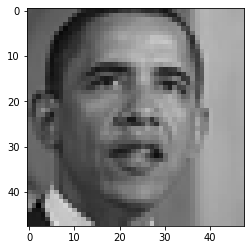

In [42]:
img = X_test[20]
pred = model.predict(np.expand_dims(img,axis=0))[0]
print("Probs -> angry:{0:.5f} disgust:{1:.5f} fear:{2:.5f} happy:{3:.5f} sadness:{4:.5f} surprise:{5:.5f}".format(pred[0],pred[1],pred[2],pred[3],pred[4],pred[5]))
plt.imshow(Image.fromarray(img.squeeze()*255),'gray')

In [ ]:
emotions= ('Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral')

## Analize model with confusion matrix

[9.6087140e-12 3.3346064e-13 4.4551845e-15 9.9963033e-01 2.5047108e-11
 7.3486828e-10 3.6968390e-04]
3


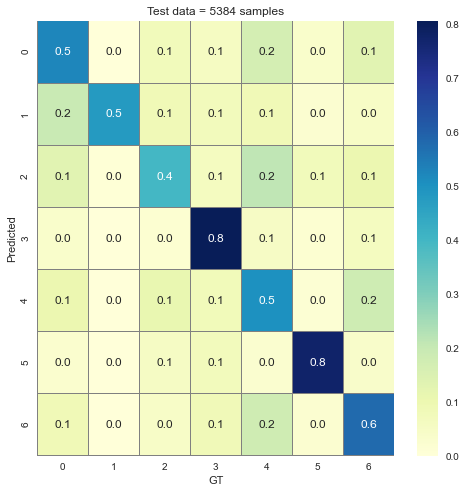

In [66]:
## Use argmax to project output probabilites as class index label
proba = model.predict(X_test)
print(proba[0])
y_pred = np.argmax(proba, axis=1)
print(y_pred[0])
y_t = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_t, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="YlGnBu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("GT")
plt.ylabel("Predicted")
plt.title(f"Test data = {len(y_pred)} samples")
plt.show()

## The model recognize happy and surprise really good, but it is not good with fear